In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix,hstack
from sklearn.model_selection import KFold,train_test_split,GridSearchCV
from xgboost import XGBRFRegressor
import warnings
warnings.filterwarnings('ignore')

In [52]:
list_train = []
count =0
with open('train.csv') as f:
    for li in f.readlines():
        li=li.replace('\n', '')
        lis = li.split(',')
        if len(lis)>132:
            li = li.replace(', .',',0.').replace(' ','')
            lis = li.split(',')
            list_train.append(lis[:-1])
        else:
            list_train.append(lis)
train = pd.DataFrame(list_train[1:],columns=list_train[0])            
num_columns = [i for i in train.columns.tolist() if 'cont' in i]
for i in num_columns:
    train[i]=train[i].astype('float64')
train['loss']=train['loss'].astype('float64')  
train['log_loss'] = np.log(train['loss'])

In [66]:
features =[x for x in train.columns if x not in ['id','loss','log_loss']]
cat_features = [x for x in train.select_dtypes(include=['object']).columns if x not in ['id','loss','log_loss']]
num_features = [x for x in train.select_dtypes(exclude=['object']).columns if x not in ['id','loss','log_loss']]

n_train = train.shape[0]
train_x = train[features]
train_y = train['log_loss']

In [67]:
for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes


In [68]:
def xg_eval_mae(yhat,dtrain):
    y=dtrain.get_label()
    return 'mae',mean_absolute_error(np.exp(y),np.exp(yhat))
dtrain=xgb.DMatrix(train_x,train['log_loss'])

In [69]:
xgb_params = {
    'seed' : 0,
    'eta':0.1,
    'colsample_bytree':0.5,
    'silent':1,
    'subsample':0.5,
    'objective':'reg:linear',
    'max_depth':5,
    'min_child_weight':3
}

In [72]:
train.shape

(194592, 133)

CV score: 1220.1355386666667
CPU times: user 3min 29s, sys: 2.11 s, total: 3min 31s
Wall time: 1min


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

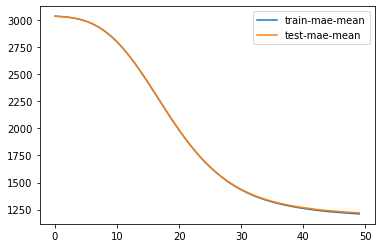

In [71]:
%%time
bst_cvl = xgb.cv(xgb_params,dtrain,num_boost_round=50,nfold=3,seed=0,feval=xg_eval_mae,maximize=False,early_stopping_rounds=10)
print('CV score:',bst_cvl.iloc[-1,:]['test-mae-mean'])
plt.figure()
bst_cvl[['train-mae-mean','test-mae-mean']].plot()

CV score : 1171.100586


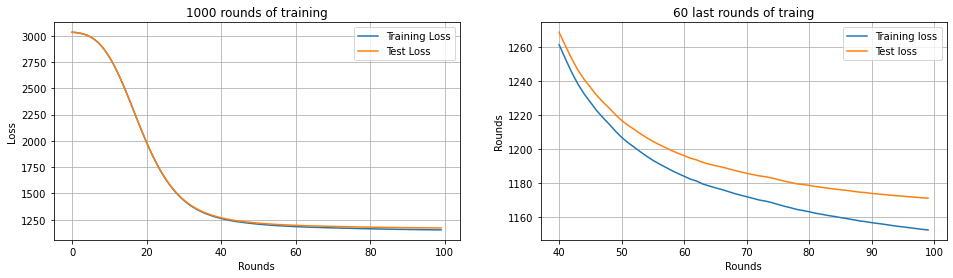

In [74]:
bst_cv2 = xgb.cv(xgb_params,dtrain,num_boost_round=100,nfold=3,seed=0,feval=xg_eval_mae,maximize=False,early_stopping_rounds=10)
print('CV score :',bst_cv2.iloc[-1,:]['test-mae-mean'])
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(16,4)
ax1.set_title('1000 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean','test-mae-mean']])
ax1.legend(['Training Loss','Test Loss'])

ax2.set_title('60 last rounds of traing')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Rounds')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean','test-mae-mean']])
ax2.legend(['Training loss','Test loss'])

In [79]:
class XGBoostRegressor(object):
    def __init__(self,**kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent':1,'objective':'reg:linear','seed':0})
    def fit(self,x_train,y_train):
        dtrain = xgb.DMatrix(x_train,y_train)
        self.bst = xgb.train(params=self.params,dtrain=dtrain,num_boost_round=self.num_boost_round,
                            feval=xg_eval_mae,maximize=False)
    def predict(self,x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    def kflod(self,x_train,y_train,nflod=5):
        dtrain = xgb.DMatrix(x_train,y_train)
        cv_rounds = xgb.cv(params=self.params,dtrain=dtrain,num_boost_round=self.num_boost_round,
                          nfold=nflod,feval=xg_eval_mae,maximize=False,early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    def plot_feature_importance(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importance')
        plt.ylabel('Feature Importance Score')
    def get_params(self,deep=True):
        return self.params
    def set_params(self,**params):
        self.params.update((params))
        return self
def mae_score(y_true,y_pred):
    return mean_absolute_error(np.exp(y_true),np.exp(y_pred))
mae_scorer = make_scorer(mae_score,greater_is_better=False)


In [81]:
bst = XGBoostRegressor(eta=0.1,colsample_bytree=0.5,subsample=0.5,max_depth=5,min_child_weight=0.5,num_boost_round=50)
bst.kflod(train_x,train_y,nflod=5)

train-mae-mean     1210.022046
train-mae-std         0.862995
train-rmse-mean       0.558961
train-rmse-std        0.000618
test-mae-mean      1218.359644
test-mae-std          6.091551
test-rmse-mean        0.562507
test-rmse-std         0.001530
Name: 49, dtype: float64

In [100]:
xgb_param_grid ={'max_depth':list(range(4,9)),'min_child_weight':list((1,3,6))}
grid = GridSearchCV(XGBoostRegressor(eta=0.1,num_boost_round=50,colsample_bytree=0.5,subsample=0.5),
                                     param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/yanshuo/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-100-2149d19ef750>", line 4, in <module>
    grid.fit(train_x,train_y)
  File "/Users/yanshuo/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Users/yanshuo/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 841, in fit
    self._run_search(evaluate_candidates)
  File "/Users/yanshuo/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 1296, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/Users/yanshuo/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 809, in evaluate_candidates
    enumerate(cv.split(X, y, groups))))
  File "/Users/yanshuo/opt/ana

TypeError: object of type 'NoneType' has no len()

In [ ]:
pd.DataFrame.from_dict(grid.cv_results_,orient = 'columns')['mean_test_score']
pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['params']
grid.best_params_,grid.best_score_

In [86]:
pd.DataFrame.from_dict(grid.cv_results_,orient = 'columns')['mean_test_score']

0    -1244.055542
1    -1243.149062
2    -1243.398317
3    -1218.580377
4    -1218.795848
5    -1218.478213
6    -1203.393831
7    -1203.556690
8    -1203.215613
9    -1194.307447
10   -1193.552480
11   -1193.143852
12   -1188.957571
13   -1188.313980
14   -1187.337005
Name: mean_test_score, dtype: float64

In [87]:
pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['params']


0     {'max_depth': 4, 'min_child_weight': 1}
1     {'max_depth': 4, 'min_child_weight': 3}
2     {'max_depth': 4, 'min_child_weight': 6}
3     {'max_depth': 5, 'min_child_weight': 1}
4     {'max_depth': 5, 'min_child_weight': 3}
5     {'max_depth': 5, 'min_child_weight': 6}
6     {'max_depth': 6, 'min_child_weight': 1}
7     {'max_depth': 6, 'min_child_weight': 3}
8     {'max_depth': 6, 'min_child_weight': 6}
9     {'max_depth': 7, 'min_child_weight': 1}
10    {'max_depth': 7, 'min_child_weight': 3}
11    {'max_depth': 7, 'min_child_weight': 6}
12    {'max_depth': 8, 'min_child_weight': 1}
13    {'max_depth': 8, 'min_child_weight': 3}
14    {'max_depth': 8, 'min_child_weight': 6}
Name: params, dtype: object

In [ ]:
def convert_grid_scores():
    _params = []
    _params_pair = []
    params_temp = grid.cv_results_['params']
    for i in range(0,len(params_temp)):
        a = list(params_temp[i].values())[0]
        b = list(params_temp[i].values())[1]
        _params_pair.append([a,b])
        _params.append(b)
    _params_mae = grid.cv_results_['mean_test_score']
    params = np.array(_params)
    grid_res = np.column_stack((params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]
_,scores = convert_grid_scores()
scores = scores.reshape(5,3)
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'],xgb_param_grid['max_depth'],scores,cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.annotate('We use this',xy=(5.95,7.95),xytext=(4,7.5),arrowprops = dict(facecolor='white'),color='red')
plt.annotate('Good for depth =7',xy=(5.95,7.05),xytext=(4,6.5),arrowprops=dict(facecolor='white'),color='red')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

In [92]:
xgb_param_grid = {'gamma':[0.1*i for i in range(0,5)]}
grid = GridSearchCV(XGBoostRegressor(eta=0.1,num_boost_round=50,max_depth=8,min_child_weight=6,colsample_bytree=0.5,
                                    subsample=0.5),param_grid=xgb_param_grid,cv=5,scoring=mae_score)
grid.fit(train_x,train_y.values)
pd1 = pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score']
pd2 = pd.DataFrame.from_dict(grid.cv_results_['params'],orient='columns')
pd.merge(pd1,pd2,left_index=True,right_index=True,how='outer')
grid.best_params_,grid.best_score_

({'gamma': 0.0}, nan)

In [91]:
xgb_param_grid = {'subsample':[0.1*i for i in rangegegege(6,9)],
                  'colsample_bytree':[0.1*i forrangein range(6,9)]}GridSearchCVidSearchCVidSearchCVidSearchCVrid = GridSearchCV(XGBoostRegressor(eta=0.1,gamma=0.2,num_boost_round=50,max_depth=8,min_child_weight=6),
                    param_grid = xgb_param_grid,cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y.values)
pd1 = pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score']
pd2 = pd.DataFrame.from_dict(grid.cv_results_['params'],orient='columns')
pd.merge(pd1,pd2,left_index=True,right_index=True,how='outer')
grid.best_params_,grid.best_score_


({'colsample_bytree': 0.7000000000000001, 'subsample': 0.8},
 -1182.537013965639)

In [97]:
_,scores = convert_grid_scores()
scores = scores.reshape(3,3)
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['subsample'],xgb_param_grid['colsample_bytree'],scores,cmap='BrBG',annote=True)
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum',xy=(0.895,0.6),xytext=(0.8,0.695),arrowprops=dict(facecolor='black'))
plt.xlabel('colsample_bytree')
plt.ylabel('subsample')
plt.grid(True)
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
xgb_param_grid={'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=50,gamma=0.2,max_depth=8,
                                     min_child_weight=6,colsamaple_bytree=0.6,subsample=0.9),
                   param_grid=xgb_param_grid, cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y.values)
pd1 = pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score']
pd2 = pd.DataFrame.from_dict(grid.cv_results_['params'],orient='columns')
a = pd.merge(pd1,pd2,left_index=True,right_index=True,how='outer')
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(a.eta,a.mean_test_score)
plt.grid(True)
plt.show()



In [ ]:
xgb_param_grid={'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100,gamma=0.2,max_depth=8,
                                     min_child_weight=6,colsamaple_bytree=0.6,subsample=0.9),
                   param_grid=xgb_param_grid, cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y.values)
pd1 = pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score']
pd2 = pd.DataFrame.from_dict(grid.cv_results_['params'],orient='columns')
b = pd.merge(pd1,pd2,left_index=True,right_index=True,how='outer')
print(grid.best_params_,grid.best_score_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA,50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(a.eta,a.mean_test_score)
plt.grid(True)
plt.show()

plt.title('50 trees VS 100 trees')
plt.plot(a.eta,a.mean_test_score,color='skyblue',label='50 trees',ls='-',marker='*')
plt.plot(b.eta,b.mean_test_score,color='red',label='100 trees',ls=':',marker='+')
plt.legend()
plt.xlabel('eta')
plt.ylabel('score')
plt.show()

In [ ]:
xgb_param_grid={'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=200,gamma=0.2,max_depth=8,
                                     min_child_weight=6,colsamaple_bytree=0.6,subsample=0.9),
                   param_grid=xgb_param_grid, cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y.values)
pd1 = pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score']
pd2 = pd.DataFrame.from_dict(grid.cv_results_['params'],orient='columns')
c = pd.merge(pd1,pd2,left_index=True,right_index=True,how='outer')
print(grid.best_params_,grid.best_score_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA,50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(a.eta,a.mean_test_score)
plt.grid(True)
plt.show()

plt.title('50 trees VS 100 trees')
plt.plot(a.eta,a.mean_test_score,color='skyblue',label='50 trees',ls='-',marker='*')
plt.plot(b.eta,b.mean_test_score,color='red',label='100 trees',ls=':',marker='+')
plt.plot(c.eta,c.mean_test_score,color='black',label='200 trees',marker='+')

plt.legend()
plt.xlabel('eta')
plt.ylabel('score')
plt.show()

In [ ]:
xgb_param_grid = {'eta':[0.075]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=200,gamma=0.2,max_depth=8,min_child_weight=6,colsample_bytree=0.6,subsample=0.9),
                    param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y.values)
pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score']
pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['params']
rslt_pd = pd.merge(pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['mean_test_score'],pd.DataFrame.from_dict(grid.cv_results_,orient='columns')['params'],
                  left_index=True,right_index=True,how='outer')

grid.best_params_,grid.best_score_



In [105]:
outmodel_test = pd.read_csv('test.csv')
for col in cat_features:
    outmodel_test[col]=outmodel_test[col].map(cat_features.get(col))
temp = grid.predict(outmodel_test[features])
precict_outmodel= np.round(np.exp(temp),4)
    

In [ ]:
from sklearn.externals import joblib
joblib.dump(grid,'grid.model')
import json
jsObj = json.dumps(category_dict)
fileObject = open('jsonFile.json','w')
fileObject.write(jsObj)
fileObject.close()


In [ ]:
import json
jsObj = json.dumps(features)
fileObject = open('features.json','w')
fileObject.write(jsObj)
fileObject.close()



In [ ]:
import json
jsObj = json.dumps(cat_features)
fileObject = open('cat_features.json','w')
fileObject.write(jsObj)
fileObject.close()
